# Naive Bayes: Spam or Ham 
```
- Dataset
    Download the sample dataset in CSV format containing two columns:
        Message: The email text content.
        Label: The classification of the email as either Spam or Ham.
    You can download a prepared dataset attached from the GClass.
    Alternatively, you can manually create your own dataset in Jupyter Notebook.
- Data Loading
    Import and load the dataset into your Jupyter Notebook file.
    There are two files: TrainingData and the TestingData. Your program should predict the probabilities of the TrainingData and test the analysison the TestingData
- Data Preprocessing
    Use CountVectorizer or any other text preprocessing library to convert the email messages into numerical features.
- Implementation
    Split the data into training and testing sets.
    Implement a Naive Bayes classifier to train the model on the dataset.
    Evaluate the model using accuracy metrics and classification reports using your formula.
- Visualization
    Create an optional visualization of word frequency in spam versus ham messages if desired.
- Prediction
    Test the model with new email messages (e.g., "Win a free prize now!" or "Meeting tomorrow at 10 AM").
    Print the predicted labels for the test messages.
```

In [93]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# metrics
from sklearn.metrics import accuracy_score

# feature engineering
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split

# cleaning text
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# handle class imbalance
from imblearn.over_sampling import RandomOverSampler

# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [94]:
# read utf-8 csv file
df_train = pd.read_csv('ml-groupings/naive_bayes/train.csv', encoding='latin1')

## Data Preparation

In [95]:
df_train.isnull().any()

label      False
message    False
dtype: bool

*No missing values*

In [96]:
df_train.head(3)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [97]:
# convert ham/spam to 0/1
df_train['label'] = df_train['label'].map({'ham': 0,  'spam': 1})

#### Check the balance of the dataset

In [98]:
df_train['label'].value_counts(normalize=True)

label
0    0.866923
1    0.133077
Name: proportion, dtype: float64

In [99]:
df_train['label'].value_counts()

label
0    3381
1     519
Name: count, dtype: int64

**Note**: We have an unbalanced dataset!

### Preprocessing features

In [100]:
# convert text to lowercase for consistency
df_train['message'] = df_train['message'].str.lower()

## Looking into the data

#### Visualize top phrases used in spam and ham emails

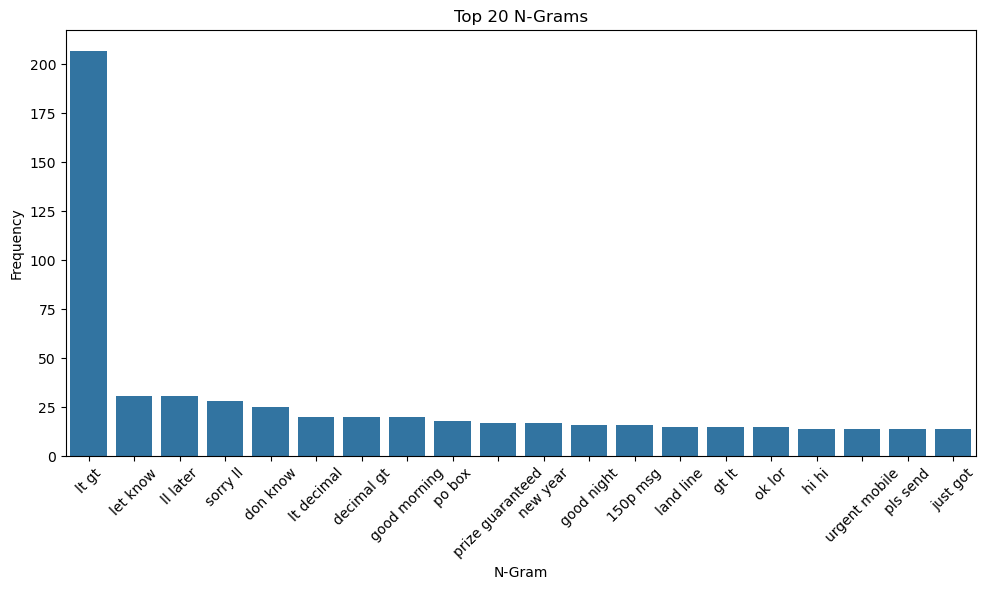

In [101]:
cv = CountVectorizer(ngram_range=(2, 2), stop_words='english') # exclude common english words
X = cv.fit_transform(df_train['message'])
sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:20]
top_ngrams = [word[0] for word in words_freq]
plt.figure(figsize=(10, 6))
sns.barplot(x=[word[0] for word in words_freq], y=[word[1] for word in words_freq])
plt.title('Top 20 N-Grams')
plt.xlabel('N-Gram')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Checking email length for spam/ham

In [102]:
def get_email_length(msg):
    return len(msg)

In [103]:
df_train['length'] = df_train['message'].apply(get_email_length)

In [104]:
# get average length of ham emails
df_train[df_train['label'] == 0].length.sum() / len(df_train[df_train['label'] == 0])

71.19195504288672

In [105]:
# get average length of spam emails
df_train[df_train['label'] == 1].length.sum() / len(df_train[df_train['label'] == 1])

139.35452793834295

This is quite insightful. It is a conventional fact that spam messages are usually longer in length.

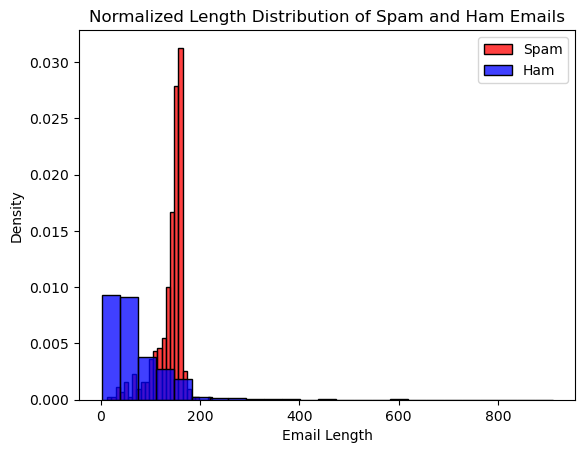

In [106]:
# normalize and compare lengths of spam and ham emails
sns.histplot(df_train[df_train['label'] == 1]['length'], bins=25, stat='density', color='red', label='Spam');
sns.histplot(df_train[df_train['label'] == 0]['length'], bins=25, stat='density', color='blue', label='Ham');
plt.legend()
plt.title('Normalized Length Distribution of Spam and Ham Emails')
plt.xlabel('Email Length')
plt.ylabel('Density')
plt.show()

In [107]:
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove links
    text = re.sub(r'http\S+', '', text)
    
    # Tokenize the text
    words = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words]
    
    # Initialize Porter Stemmer
    stemmer = PorterStemmer()
    
    # Perform stemming
    stemmed_words = [stemmer.stem(word) for word in filtered_words]
    
    # Join the stemmed words back into a single string
    cleaned_text = ' '.join(stemmed_words)
    
    return cleaned_text

df_train['clean_text'] = df_train['message'].apply(lambda x: clean_text(x))

#### Data balancing
RandomOverSamplet() is a technique used to balance the classes in a dataset by randomly duplicating examples from the minority class

In [108]:
X = df_train.drop('label', axis=1)
y = df_train['label']

# initialize resampling technique
oversampler = RandomOverSampler()

# do the resampling
X_resampled, y_resampled = oversampler.fit_resample(X, y)

df_balanced = pd.DataFrame(X_resampled, columns=X.columns)
df_balanced['label'] = y_resampled

# check balanced classes
df_balanced['label'].value_counts()


label
0    3381
1    3381
Name: count, dtype: int64

#### Data Splitting / TF-IDF Vectorization

##### Difference Between TF-IDF and CountVectorizer

- **CountVectorizer**:
  - Converts a collection of text documents to a matrix of token counts.
  - Each entry in the matrix represents the frequency of a word in a document.
  - Does not consider the importance of words; all words are treated equally.

- **TF-IDF (Term Frequency-Inverse Document Frequency)**:
  - A statistical measure that evaluates the importance of a word in a document relative to a collection.
  - Considers both the frequency of a word in a document and how common or rare the word is across all documents.
  - Helps to reduce the weight of common words and increase the weight of rare words, making it more effective for information retrieval and text mining.

In [113]:
# copy of df_train
df = df_train.copy()
del df['length'] # remove length from the copy

# split to train and validation
X_train, X_val, y_train, y_val = train_test_split(df_balanced['clean_text'], df_balanced['label'].values, test_size=0.2, random_state=42) # use the balanced dataset

# use TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_val)

In [114]:
# must be equal length
assert len(X_train) == len(y_train)
assert len(X_val) == len(y_val)

## Feature Engineering

#### Verifying transformation

In [231]:
sample = X_train.iloc[0]
x = cv.transform([sample['message']])

In [232]:
sample

label                                    0
message    kallis wont bat in 2nd innings.
Name: 0, dtype: object

In [233]:
print(x)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 5 stored elements and shape (1, 6456)>
  Coords	Values
  (0, 319)	1
  (0, 993)	1
  (0, 3031)	1
  (0, 3215)	1
  (0, 6299)	1


## Naive Bayes

In [234]:
X_spam = X[X_train['label'] == 1]
X_ham = X[X_train['label'] == 0]

# sum of classes
spam_word_counts = np.array(X_spam.sum(axis=0)).flatten()
ham_word_counts = np.array(X_ham.sum(axis=0)).flatten()

# total words
total_spam_words = spam_word_counts.sum()
total_ham_words = ham_word_counts.sum()

vocab_size = len(cv.vocabulary_)

# get prior probabilities
train_length = len(X_train)
prior_proba_ham = np.sum(y_train == 0) / train_length
prior_proba_spam = np.sum(y_train == 1)  / train_length
prior_proba_ham, prior_proba_spam

(np.float64(0.8634615384615385), np.float64(0.13653846153846153))

Here, we are going to use **Laplace smoothing** where

```
xi + a / N + ad
```

In [235]:
# laplace smoothing, add a=1, d=vocab_size to counts and then increase denominator by vocab size
# this is to avoid cases where spam/ham_word_counts is zero as it can impact the result
a = 1 # regularization value
word_proba_spam = (spam_word_counts + a) / (total_spam_words + a * vocab_size)
word_proba_ham = (ham_word_counts + a) / (total_ham_words + a * vocab_size)

In [236]:
def predict_proba_ham(message):
    X = cv.transform([message])
    indices = X.indices
    result = prior_proba_ham
    for index in indices:
        result *= (word_proba_ham[index])

    return result

def predict_proba_spam(message):
    X = cv.transform([message])
    indices = X.indices
    result = prior_proba_spam
    for index in indices:
        result *= (word_proba_spam[index])

    return result

def predict(message):
    ham_proba = predict_proba_ham(message)
    spam_proba = predict_proba_spam(message)
    return 0 if ham_proba > spam_proba else 1

In [237]:
df_result = pd.DataFrame({
    'prediction': X_val['message'].apply(predict).values,
    'actual': y_val
})

In [238]:
print(f"Spam or Ham Accuracy: {accuracy_score(df_result.actual, df_result.prediction)}")

Spam or Ham Accuracy: 0.9871794871794872


## Full Training

In [242]:
# initialize cv
cv = CountVectorizer()

# fit transform
X = cv.fit_transform(df_train['message'].values)

X_spam = X[df_train['label'] == 1]
X_ham = X[df_train['label'] == 0]

# sum of classes
spam_word_counts = np.array(X_spam.sum(axis=0)).flatten()
ham_word_counts = np.array(X_ham.sum(axis=0)).flatten()

# total words
total_spam_words = spam_word_counts.sum()
total_ham_words = ham_word_counts.sum()

vocab_size = len(cv.vocabulary_)

# get prior probabilities
train_length = len(X_train)
prior_proba_ham = np.sum(y_train == 0) / train_length
prior_proba_spam = np.sum(y_train == 1)  / train_length
prior_proba_ham, prior_proba_spam

# laplace smoothing, add a=1, d=vocab_size to counts and then increase denominator by vocab size
# this is to avoid cases where spam/ham_word_counts is zero as it can impact the result
a = 1 # regularization value
word_proba_spam = (spam_word_counts + a) / (total_spam_words + a * vocab_size)
word_proba_ham = (ham_word_counts + a) / (total_ham_words + a * vocab_size)

#### Training Set Accuracy

In [248]:
df_result = pd.DataFrame({
    'prediction': df_train['message'].apply(predict).values,
    'actual': df_train['label']
})
print(f"Spam or Ham Accuracy: {accuracy_score(df_result.actual, df_result.prediction)}")

Spam or Ham Accuracy: 0.9951282051282051


#### Test Set Accuracy

In [245]:
df_test = pd.read_csv('test.csv', encoding='latin1')

In [247]:
df_test.head()

,message
0,That depends. How would you like to be treated...
1,"Right on brah, see you later"
2,Waiting in e car 4 my mum lor. U leh? Reach ho...
3,Your 2004 account for 07XXXXXXXXX shows 786 un...
4,Do you want a new video handset? 750 anytime a...


In [253]:
df_test['prediction'] = df_test['message'].apply(predict).values
df_test['category'] = df_test['message'].apply(lambda msg: 'spam' if predict(msg) == 1 else 'ham')

df_test.head()

,message,prediction,category
0,That depends. How would you like to be treated...,0,ham
1,"Right on brah, see you later",0,ham
2,Waiting in e car 4 my mum lor. U leh? Reach ho...,0,ham
3,Your 2004 account for 07XXXXXXXXX shows 786 un...,1,spam
4,Do you want a new video handset? 750 anytime a...,1,spam
